In [1]:
import hisepy
import os
import pandas as pd
import re
import scanpy as sc

In [4]:
meta_data=pd.read_csv("hise_meta_data_2023-11-19.csv")

In [5]:
adata=sc.read_h5ad('adata_all_raw.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 2093787 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id'

In [6]:
adata

AnnData object with n_obs × n_vars = 2093078 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id'

In [7]:
matching_strings = []

# Iterate through the list and find matching strings
for string in  list(meta_data['file.name.downloaded']):
    match = re.search(r'PB\d{5}-\d+', string)
    if match:
        matching_strings.append(match.group())


In [8]:
meta_data['pbmc_sample_id']=matching_strings

In [10]:
CMV=pd.read_csv('CMV_20220718_UPBR.csv')
BMI=pd.read_csv('BR-BR-Clinical-BMI.csv')
CMV=CMV.merge(BMI, on='subject.subjectGuid', how='left')
meta_data=meta_data.merge(CMV, on='subject.subjectGuid', how='left')

df=adata.obs.merge(meta_data[['pbmc_sample_id', 'subject.biologicalSex',
        'subject.ethnicity', 'subject.partnerCode',
       'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid','sample.visitName', 
           'sample.visitDetails', 'subject.birthYear','CMV.IgG.Serology.Result.Interpretation', 'BMI']], on='pbmc_sample_id', how='left')

In [11]:
col_list=['subject.biologicalSex','subject.ethnicity', 'subject.partnerCode',
          'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 
          'sample.visitDetails', 'subject.birthYear','CMV.IgG.Serology.Result.Interpretation', 
          'BMI']

In [15]:
def process_sample(sample_id):
    seurat_labels = pd.read_csv(f'Labels_20231119/{sample_id}.csv')
    seurat_labels = seurat_labels[['barcodes', 'predicted.celltype.l1.score', 'predicted.celltype.l1',
                                   'predicted.celltype.l2.score', 'predicted.celltype.l2',
                                   'predicted.celltype.l3.score', 'predicted.celltype.l3',
                                   'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5']]
    celltypeist_labels = pd.read_csv(f'Labels_Celltypist/{sample_id}_Low.csv')
    celltypeist_labels = celltypeist_labels[['barcodes', 'predicted_labels', 'majority_voting']]
    celltypeist_labels.columns = ['barcodes', 'predicted_labels_celltypist', 'majority_voting_celltypist']
    
    merged_df = pd.merge(seurat_labels, celltypeist_labels, on='barcodes', how='left')
    
    return merged_df

In [16]:
from concurrent.futures import ThreadPoolExecutor


dfs = []  # To store the resultant dataframes
with ThreadPoolExecutor(max_workers=60) as executor:
    dfs = list(executor.map(process_sample, meta_data['pbmc_sample_id']))

# Combining all dataframes in the list `dfs`
final_df = pd.concat(dfs, ignore_index=True)

In [17]:
df=df.merge(final_df, on='barcodes', how='left')

In [18]:
doublet_scores=pd.read_parquet('doublet_score.parquet')
df=df.merge(doublet_scores, on='barcodes', how='left')

In [19]:
col_list=['subject.biologicalSex','subject.ethnicity', 'subject.partnerCode',
          'subject.race', 'subject.subjectGuid', 
          'cohort.cohortGuid', 'sample.visitName', 
          'sample.visitDetails', 'subject.birthYear',
          'CMV.IgG.Serology.Result.Interpretation', 'BMI', 
          'predicted.celltype.l1.score', 'predicted.celltype.l1',
          'predicted.celltype.l2.score', 'predicted.celltype.l2',
          'predicted.celltype.l3.score', 'predicted.celltype.l3',
          'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5',
          'predicted_labels_celltypist', 'majority_voting_celltypist',
          'predicted_doublet','doublet_score']

In [20]:
for i in col_list:
    adata.obs[i]=list(df[i])

In [21]:
adata=adata[adata.obs['predicted_doublet']==False]

In [22]:
adata.obs['pbmc_sample_id'].nunique()

108

In [23]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)

... storing 'subject.biologicalSex' as categorical
... storing 'subject.ethnicity' as categorical
... storing 'subject.partnerCode' as categorical
... storing 'subject.race' as categorical
... storing 'subject.subjectGuid' as categorical
... storing 'cohort.cohortGuid' as categorical
... storing 'sample.visitName' as categorical
... storing 'sample.visitDetails' as categorical
... storing 'CMV.IgG.Serology.Result.Interpretation' as categorical
... storing 'BMI' as categorical
... storing 'predicted.celltype.l1' as categorical
... storing 'predicted.celltype.l2' as categorical
... storing 'predicted.celltype.l3' as categorical
... storing 'predicted.celltype.l2.5' as categorical
... storing 'predicted_labels_celltypist' as categorical
... storing 'majority_voting_celltypist' as categorical


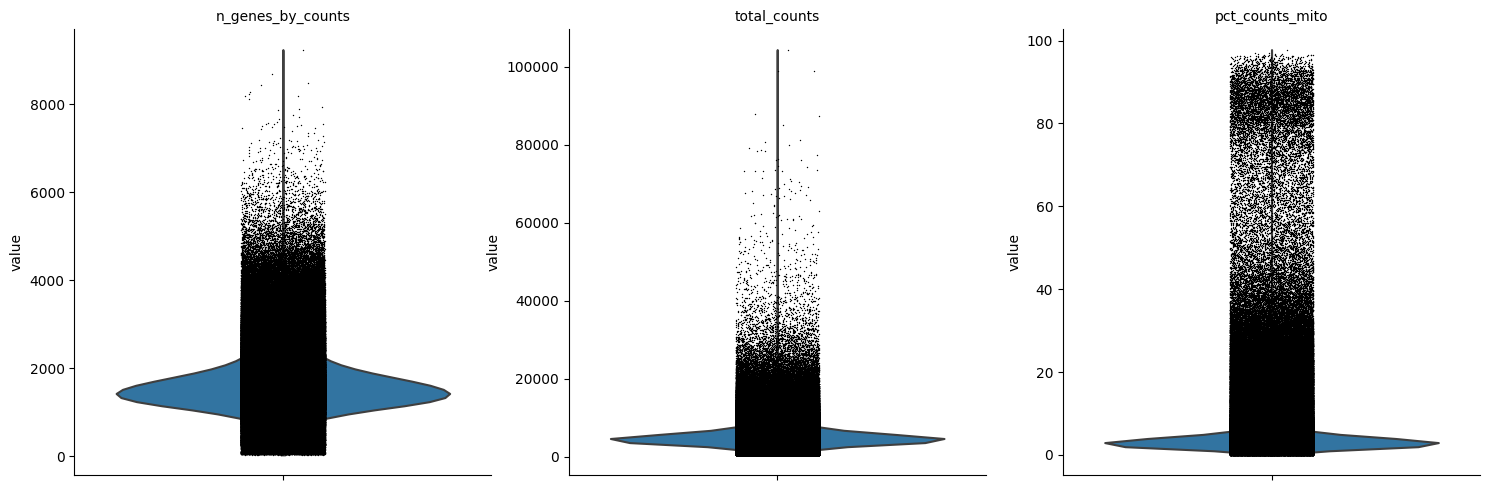

In [24]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mito'],
              multi_panel=True)

In [25]:
adata=adata[(adata.obs["pct_counts_mito"] <10) & (adata.obs["n_genes"] <5000) &(adata.obs["n_genes"] >200) ]

In [26]:
adata.raw=adata

In [27]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [28]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]]

In [29]:
sc.pp.scale(adata)

In [30]:
sc.tl.pca(adata, svd_solver='arpack')

In [31]:
sce.pp.harmony_integrate(adata, 'cohort.cohortGuid',max_iter_harmony = 20)

2023-11-20 03:56:38,141 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2023-11-20 04:08:17,381 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2023-11-20 04:08:26,190 - harmonypy - INFO - Iteration 1 of 20
Iteration 1 of 20
2023-11-20 04:23:37,673 - harmonypy - INFO - Iteration 2 of 20
Iteration 2 of 20
2023-11-20 04:39:06,469 - harmonypy - INFO - Iteration 3 of 20
Iteration 3 of 20
2023-11-20 04:53:22,282 - harmonypy - INFO - Iteration 4 of 20
Iteration 4 of 20
2023-11-20 04:58:23,194 - harmonypy - INFO - Iteration 5 of 20
Iteration 5 of 20
2023-11-20 05:03:27,080 - harmonypy - INFO - Converged after 5 iterations
Converged after 5 iterations


In [32]:
sc.pp.neighbors(adata, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata)

In [33]:
adata.write_h5ad('adata_processed_before_leiden.h5ad')

In [ ]:
sc.tl.leiden(adata)

In [ ]:
adata.write_h5ad('adata_processed.h5ad')

In [37]:
adata

AnnData object with n_obs × n_vars = 1952772 × 1237
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'subject.biologicalSex', 'subject.ethnicity', 'subject.partnerCode', 'subject.race', 'subject.subjectGuid', 'cohort.cohortGuid', 'sample.visitName', 'sample.visitDetails', 'subject.birthYear', 'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.5', 'predicted_labels_celltypist', 'majority_voting_celltypist', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top

In [3]:
adata=sc.read_h5ad('adata_processed.h5ad')

<Axes: title={'center': 'predicted.celltype.l2.5'}, xlabel='UMAP1', ylabel='UMAP2'>

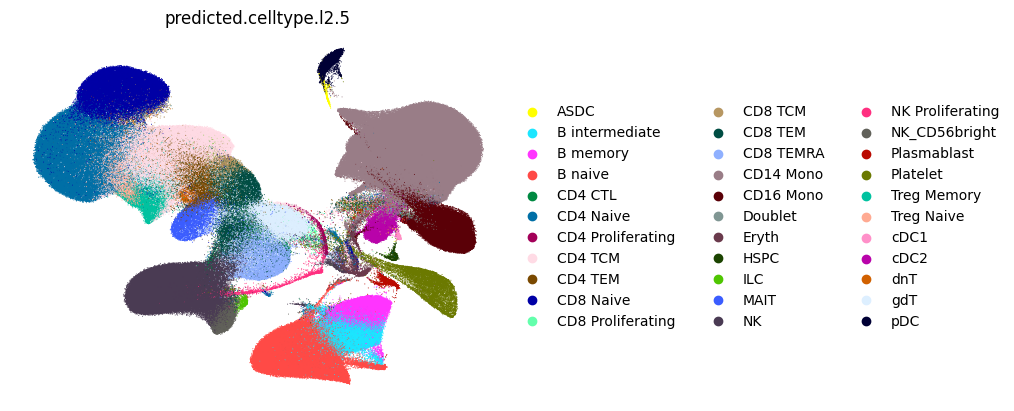

In [38]:
sc.pl.umap(adata, color=['predicted.celltype.l2.5'], size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'predicted_labels_celltypist'}, xlabel='UMAP1', ylabel='UMAP2'>

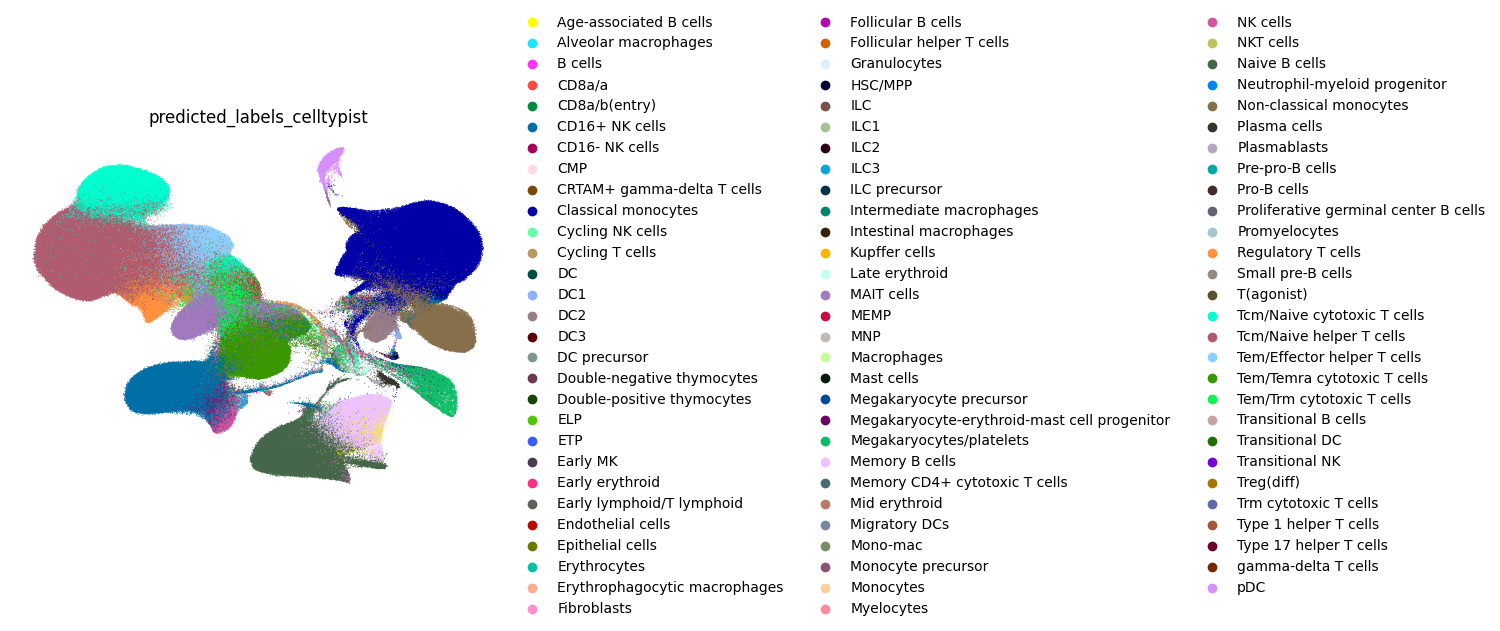

In [39]:
sc.pl.umap(adata, color=['predicted_labels_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'majority_voting_celltypist'}, xlabel='UMAP1', ylabel='UMAP2'>

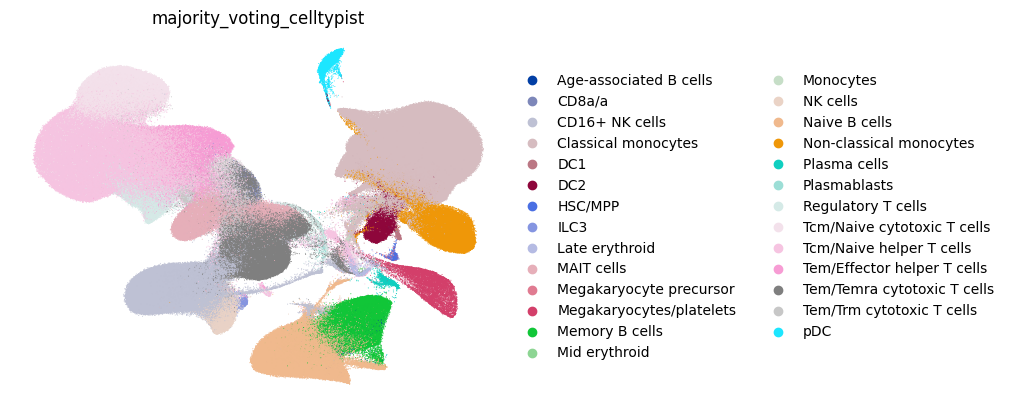

In [40]:
sc.pl.umap(adata, color=['majority_voting_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

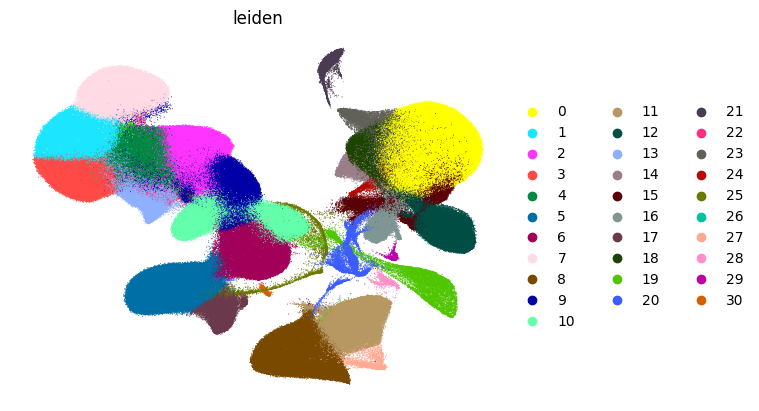

In [41]:
sc.pl.umap(adata, color=['leiden'], size=2,show=False,ncols=1 ,frameon=False)